In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback
from scipy.linalg import svd, inv, eig
sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    OUTPUT_DIR = "./output/"
    #google.colab.drive.mount('/content/gdrive')
    #os.chdir('/content/gdrive/My Drive/projects/xxx')
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running locally on beta.


In [2]:
import utils

In [306]:
run = utils.TrainingRun()
#P, model = run.load_state("../output/mlp_grokking-230411-124054")
P, model = run.load_state("../output/mlp_grokking-230412-092835")
#P, model = run.load_state("../output/mlp_grokking-230412-100753")

In [307]:
weights = model.get_weights()
[ w.shape for w in weights ]

[(113, 128), (2, 128, 1, 128), (128, 113)]

In [308]:
w1 = weights[1].reshape(2*128,128)
w10 = weights[1][0].reshape(128,128)
w11 = weights[1][1].reshape(128,128)

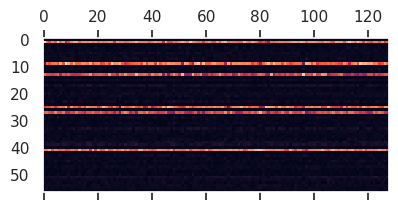

In [309]:
fig, ax = plt.subplots(1,1, figsize=(5,2))
#ax.matshow(model.get_weights()[2])
ax.matshow(np.abs(np.fft.rfft(weights[0], axis=0)))
ax.grid(False)              

In [277]:
m = weights[0]
u, s, vh = svd(m)
#u, s, vh = svd(w1)
u.shape, s.shape, vh.shape

((113, 113), (113,), (128, 128))

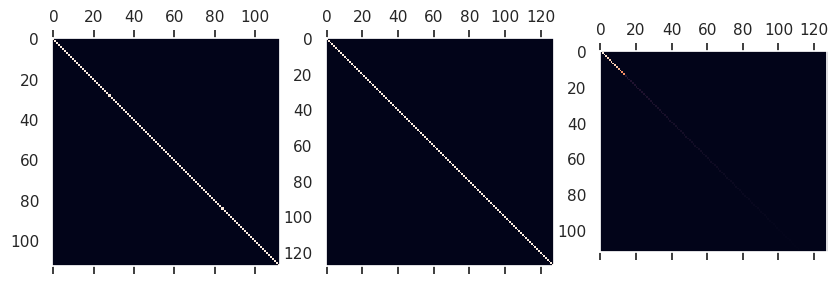

In [278]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].matshow(u.T @ u )
ax[1].matshow(vh @ vh.T)
ax[2].matshow(u.T @ m @ vh.T)
ax[0].grid(False)
ax[1].grid(False);
ax[2].grid(False);

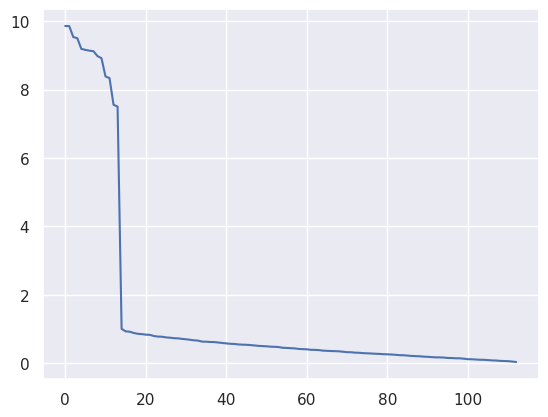

In [279]:
plt.plot(s)

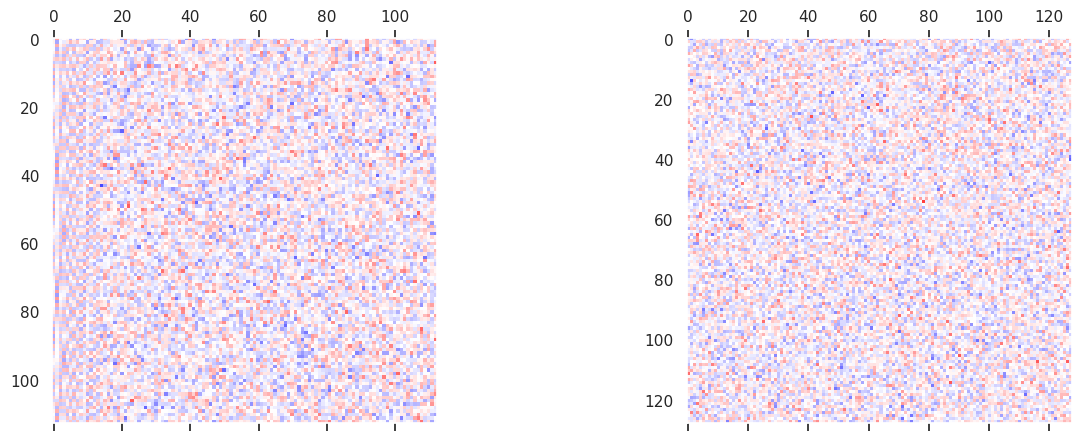

In [103]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].matshow(u, cmap="bwr", vmin=-.5, vmax=.5)
ax[1].matshow(vh, cmap="bwr", vmin=-.5, vmax=.5)
ax[0].grid(False)
ax[1].grid(False);

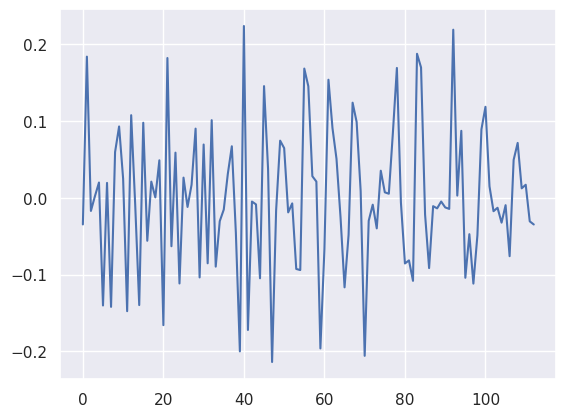

In [97]:
def one_hot(i, n=113):
    v = np.zeros(n, dtype=np.float32)
    v[i] = 1.0
    return v


plt.plot(one_hot(0) @ u)

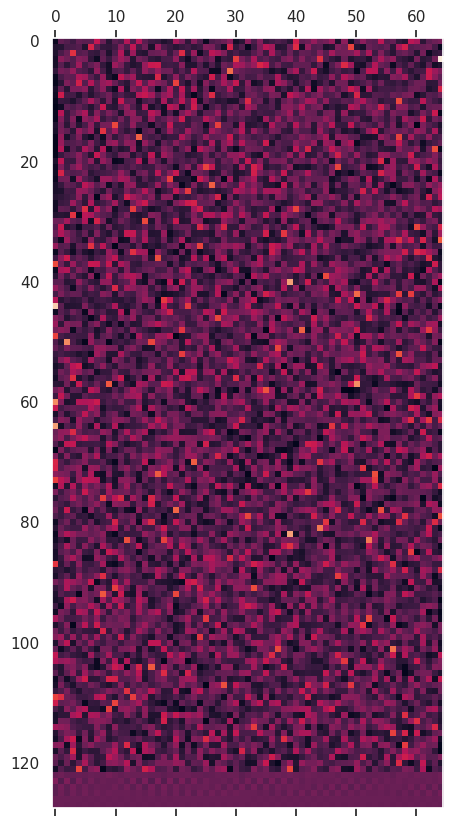

In [85]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.matshow(np.abs(np.fft.rfft(vh, axis=1)))
ax.grid(False)              

In [48]:
def abs_fft(x, axis=-1):
    return np.abs(np.fft.rfft(x, axis=axis))

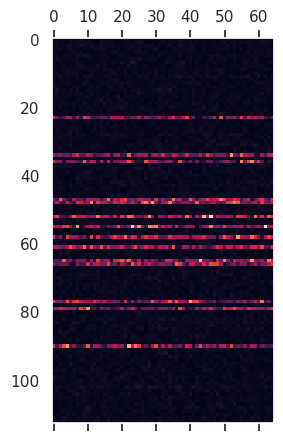

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.matshow(np.abs(np.fft.rfft2(weights[0])))
ax.grid(False)

In [310]:
weights = model.get_weights()
print([ w.shape for w in weights ])

w_emb = weights[0]
w_mlp = weights[1].reshape(2,128,128)
w_uem = weights[2]

print(w_emb.shape, w_mlp.shape, w_uem.shape)

[(113, 128), (2, 128, 1, 128), (128, 113)]
(113, 128) (2, 128, 128) (128, 113)


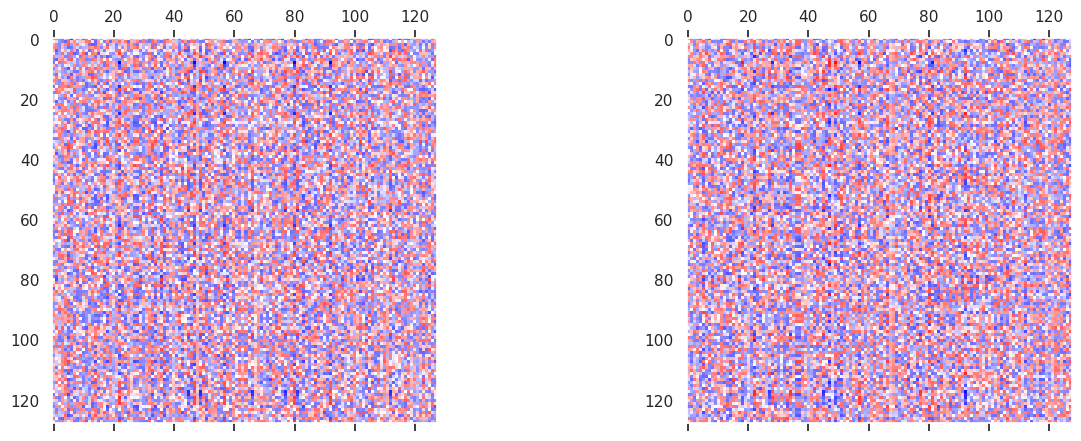

In [311]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].matshow(w_mlp[0], cmap="bwr", vmin=-.5, vmax=.5)
ax[1].matshow(w_mlp[1], cmap="bwr", vmin=-.5, vmax=.5)
ax[0].grid(False)
ax[1].grid(False);

In [312]:
u_emb, s_emb, vt_emb = svd(w_emb)
w_emb_diag = u_emb.T @ w_emb @ vt_emb.T
#plt.matshow(w_emb_diag)

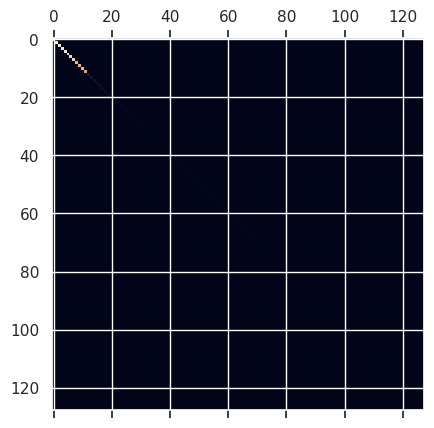

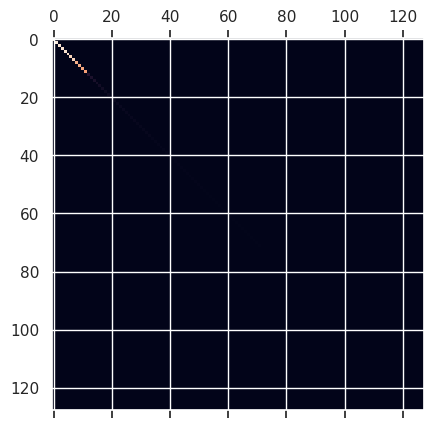

In [313]:
u_mlp, vt_mlp, s_mlp, w_mlp_diag = [None, None], [None, None], [None, None], [None, None]

for i in range(2):
    u_mlp[i], s_mlp[i], vt_mlp[i] = svd(w_mlp[i])
    w_mlp_diag[i] = u_mlp[i].T @ w_mlp[i] @ vt_mlp[i].T
    plt.matshow(w_mlp_diag[i])

In [314]:
extractor = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])

In [315]:
ext_out = extractor.predict([[1,2]])
print([ o.shape for o in ext_out ])


1/1 [==============================] - 0s 102ms/step
[(1, 2), (1, 2, 128), (1, 2, 128, 1), (1, 1, 1, 128), (1, 1, 1, 128), (1, 128), (1, 113)]


In [316]:
def one_hot(i, n=113):
    v = np.zeros(n, dtype=np.float32)
    v[i] = 1.0
    return v

In [317]:
v1 = one_hot(1) @ w_emb @ w_mlp[0]
v2 = one_hot(2) @ w_emb @ w_mlp[1]

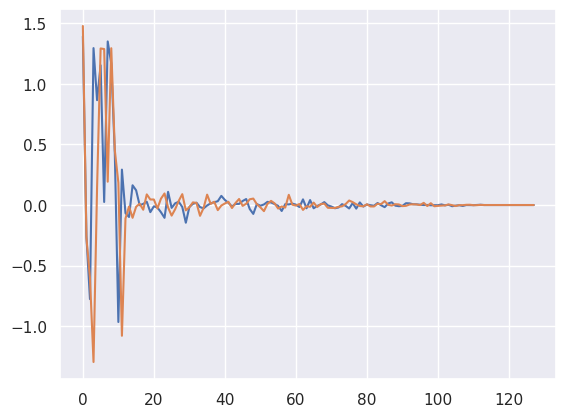

In [334]:
v1 = one_hot(1) @ u_emb @ w_emb_diag# @ vt_emb @ u_mlp[0] @ w_mlp_diag[0] @ vt_mlp[0]
v2 = one_hot(2) @ u_emb @ w_emb_diag# @ vt_emb @ u_mlp[1] @ w_mlp_diag[1] @ vt_mlp[1]
plt.plot(v1)
plt.plot(v2)

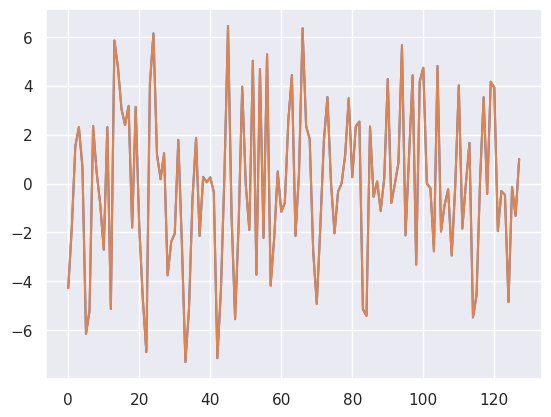

In [319]:
plt.plot(v1 + v2)
plt.plot(ext_out[3].reshape(-1))
#plt.plot(ext_out[4].reshape(-1))

In [320]:
def plot_matrix(m, ax):
    mmax = np.max(np.abs(m))
    ax.matshow(m, cmap="bwr", vmin=-mmax, vmax=mmax)
    ax.grid(False)

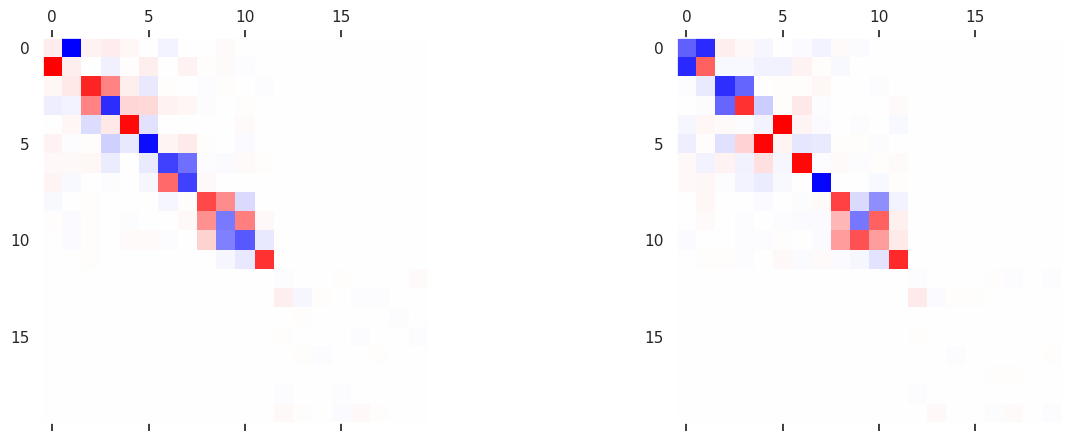

In [346]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_matrix((vt_emb @ u_mlp[0] @ w_mlp_diag[0])[:20,:20], ax[0])
plot_matrix((vt_emb @ u_mlp[1] @ w_mlp_diag[1])[:20,:20], ax[1]);

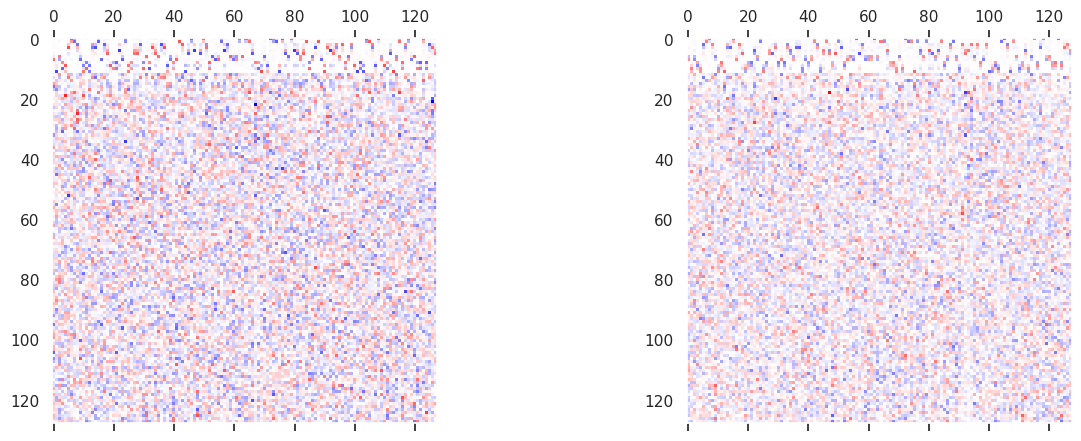

In [353]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_matrix((vt_mlp[0])[:,:], ax[0])
plot_matrix((vt_mlp[1])[:,:], ax[1]);

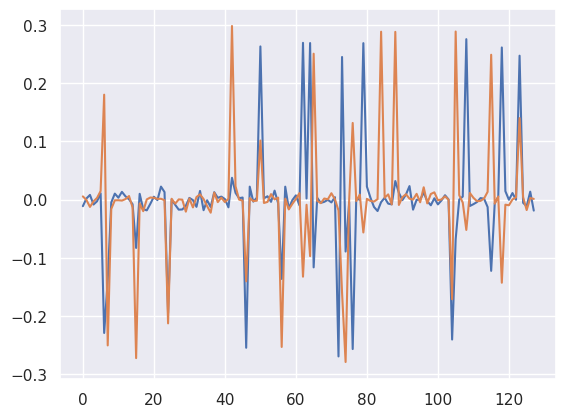

In [358]:
plt.plot(vt_mlp[0][0]);
plt.plot(vt_mlp[0][1]);

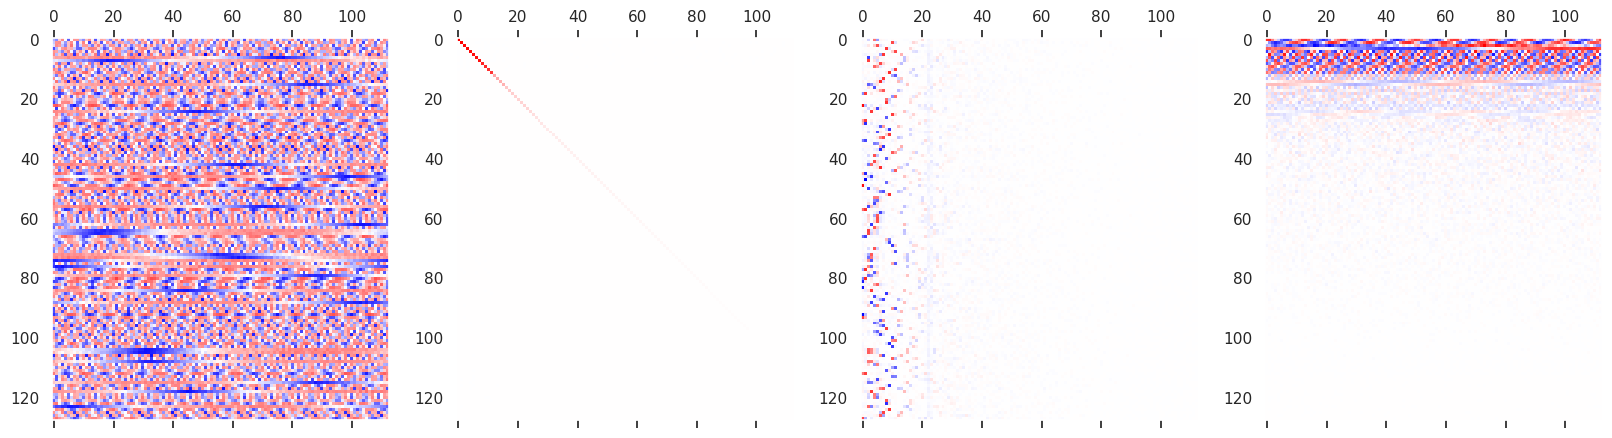

In [363]:
u_uem, s_uem, vt_uem = svd(w_uem)
w_uem_diag = u_uem.T @ w_uem @ vt_uem.T
fig, axs = plt.subplots(1,4, figsize=(20,5))
plot_matrix(w_uem, axs[0])
plot_matrix(w_uem_diag, axs[1])
plot_matrix(u_uem @ w_uem_diag, axs[2])
plot_matrix(w_uem_diag @ vt_uem, axs[3]);

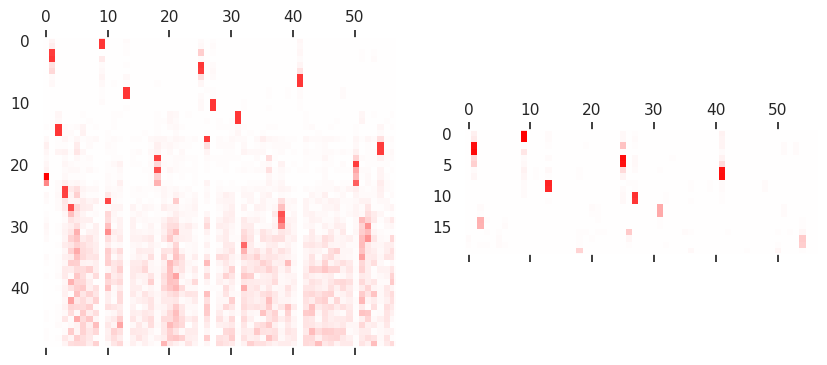

In [383]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plot_matrix(np.abs(np.fft.rfft(vt_uem, axis=1))[:50], axs[0])
plot_matrix(np.abs(np.fft.rfft(w_uem_diag @ vt_uem, axis=1))[:20], axs[1])

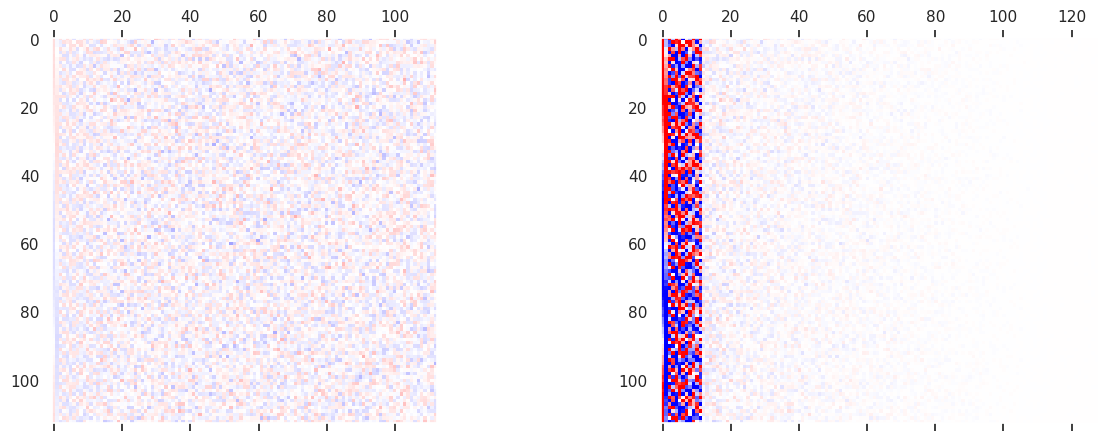

In [324]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].matshow(u_emb, cmap="bwr", vmin=-1, vmax=1)
ax[1].matshow(u_emb @ w_emb_diag, cmap="bwr", vmin=-1, vmax=1)
ax[0].grid(False)
ax[1].grid(False);

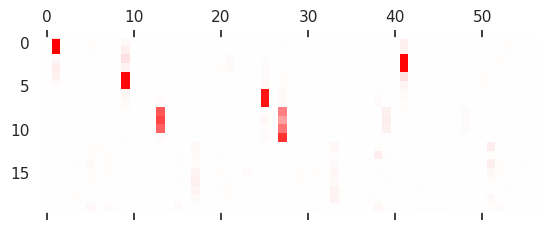

In [351]:
fig, ax = plt.subplots(1,1)
plot_matrix(np.abs(np.fft.rfft(u_emb @ w_emb_diag, axis=0))[:,:20].T, ax)

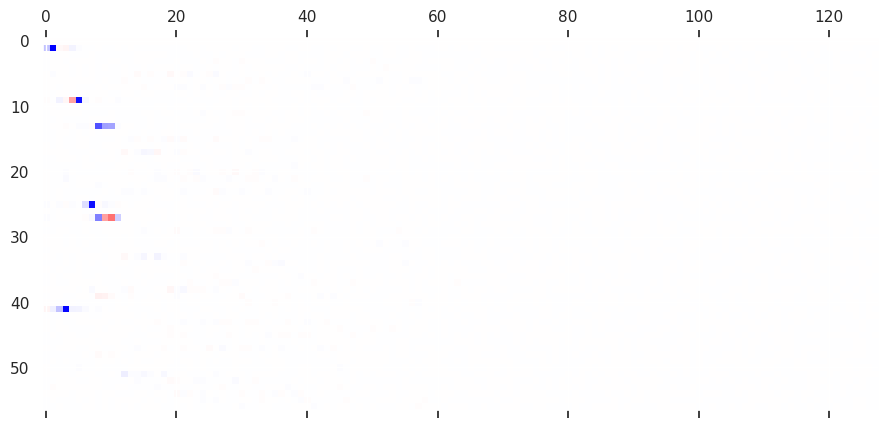

In [326]:
mi = np.imag(np.fft.rfft(u_emb @ w_emb_diag, axis=0))
mmax = np.max(np.abs(mi))
plt.matshow(mi, cmap="bwr", vmin=-mmax, vmax=mmax);

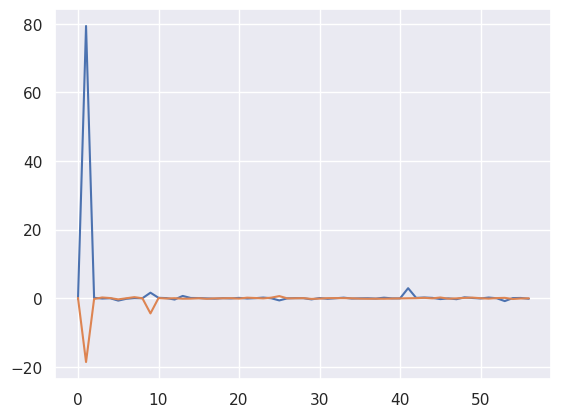

In [333]:
for i in range(2):
    plt.plot(mr[:,i]);

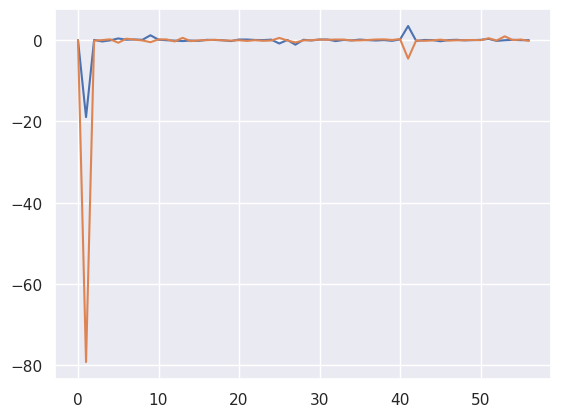

In [332]:
for i in range(2):
    plt.plot(mi[:,i]);

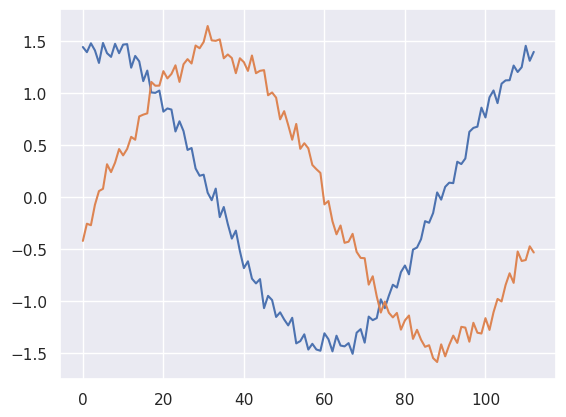

In [330]:
plt.plot((u_emb @ w_emb_diag)[:,:2]);

In [336]:
m = u_emb @ w_emb_diag
m.shape

(113, 128)

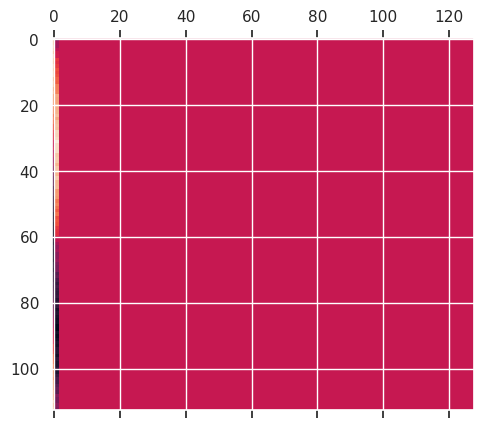

In [364]:
mask = np.zeros_like(m)
mask[:,:2] = 1
plt.matshow(m * mask)

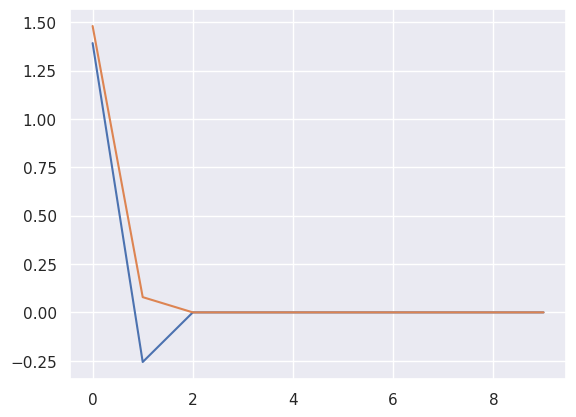

In [372]:
v1 = one_hot(1) @ ((u_emb @ w_emb_diag) * mask)# @ vt_emb @ u_mlp[0] @ w_mlp_diag[0] @ vt_mlp[0]
v2 = one_hot(5) @ ((u_emb @ w_emb_diag) * mask)# @ vt_emb @ u_mlp[1] @ w_mlp_diag[1] @ vt_mlp[1]
plt.plot(v1[:10])
plt.plot(v2[:10])
#plt.plot(v1+v2)